# Introduction

In this course project for a marketing team at Megalines telecommunications company, I have been tasked to help identify which of the two plans offered to the customers is more profitable. Using a small sample of 500 customers and their behavior in regards to messaging, calls and Internet usage from the year 2018. we will conduct a preliminary analysis to investigate the revenue distribution of customers in each plan. Followed by the statistical testing to compare distributions from revenue and the comparison of how similar to customers in New York state, the most populous area, is to other states in the data. Following this I will attempt to offer conclusions as to which plan is more profitable.

*Note:* 

Megalines rounds seconds up to minutes and megabytes to gigabytes. 
- For calls, each individual call is rounded up: even if the call is one second, it will be counted as one minute. 
- For web traffic, individual web sessions are not rounded up.
- Instead, the total for the month is rounded up. 
    - If someone uses over 1000 megabytes this month, they will be charged for 2 gigabytes.

## Libraries 

In [172]:
import pandas as pd
import scipy as py
from scipy import stats as st 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import statistics as stats
import re

**DataSets**

keys for all data sets "user_id"

"id" in calls and message data represent unique instances for each user. ex: '1000'+'_93' == 'user_id'+ '_id'



`calls_data` - multiple values for calls for each 'user_id'.

- "duration" is the time of the call. each call has a date in "call_date"
- 137735 rows total for the 500 unique "user_ids"
<br>

`messages_data` - messages for each 'user_id'
- the count of messages are are in the number of unique "id" per 'user_id'
<br>

`internet_data` - megabites uses per session in each 'id'
<br>

`plans_data` - service and cost info for each plan and service. 
- slimits for each plan
- price for overages
<br>

`user_data` - General customer information. 
 - 'first_name' & 'last_name' 
 - 'age'
 - 'city', contains city and state
 - 'reg_date', data of registration
 - 'tariff', plan for this 'user_id'
 - 'churn_date' - "nan" values for current users

In [173]:
# Load the data files into different DataFrames
calls_data = pd.read_csv(
    '/Users/ericross/Desktop/datasets/megaline_calls.csv',
    parse_dates=['call_date']
)

In [174]:
messages_data = pd.read_csv(
    '/Users/ericross/Desktop/datasets/megaline_messages.csv',
    parse_dates=['message_date']
)

In [175]:
internet_data = pd.read_csv(
    '/Users/ericross/Desktop/datasets/megaline_internet.csv',
    parse_dates=['session_date']
)

In [176]:
plans_data = pd.read_csv(
    '/Users/ericross/Desktop/datasets/megaline_plans.csv'
)

In [177]:
users_data = pd.read_csv(
    '/Users/ericross/Desktop/datasets/megaline_users.csv',
    parse_dates=['reg_date']
)

# Preprocessing

## Plans_data

In [178]:
# Print a sample of data for plans
plans_data


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


## Users_data

In [179]:
# Print the general/summary information about the users' DataFrame
users_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  34 non-null     object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 31.4+ KB


In [180]:
users_data.rename(columns={'city': 'location'}, inplace=True)


In [181]:
users_data['user_id'].duplicated().sum()

0

In [182]:
users_data['reg_date'].min(),users_data['reg_date'].max()


(Timestamp('2018-01-01 00:00:00'), Timestamp('2018-12-31 00:00:00'))

In [183]:
del users_data['first_name']
del users_data['last_name']

### Enrich data

In [185]:
import re

users_data['state'] = users_data['location'].str.extract(r',\s*([A-Za-z]+(?:\s*-?[A-Za-z]+)*)')
users_data['state'] = users_data['state'].str.replace(r' MSA', '')

users_data['state'].value_counts()

state
NY-NJ-PA       80
CA             78
TX             39
FL             25
IL-IN-WI       19
PA-NJ-DE-MD    17
MI             16
GA             14
WA             13
TN             12
MA-NH          12
DC-VA-MD-WV    11
MN-WI          11
AZ             11
OH              9
LA              9
CO              9
OR-WA           8
NC-SC           8
OH-KY-IN        8
SC              7
NV              7
CT              6
NY              6
IN              6
OK              6
PA              5
KY-IN           5
HI              5
AL              4
VA-NC           4
MD              4
VA              4
RI-MA           3
UT              3
WI              3
MO-IL           3
NM              2
MO-KS           2
NE-IA           2
TN-MS-AR        2
NC              2
Name: count, dtype: int64

In [186]:
users_data['month'] = users_data['reg_date'].dt.month
users_data.head()

,user_id,age,location,reg_date,plan,churn_date,state,month
0,1000,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN,GA,12
1,1001,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN,WA,8
2,1002,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN,NV,10
3,1003,52,"Tulsa, OK MSA",2018-01-28,surf,NaN,OK,1
4,1004,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN,WA,5


In [187]:
users_data['tariff_id'] = np.where(users_data['plan'] == 'ultimate', 1, 0)

In [188]:
users_data['tariff_id'].value_counts()

tariff_id
0    339
1    161
Name: count, dtype: int64

 **Comment:** plot the share of plans in the data, with a Pie chart. 

### Fix Churn Date columns

In [189]:
users_data.churn_date.fillna(users_data['reg_date'].max(),inplace=True)

users_data['churn'] =  np.where(users_data['churn_date'] == users_data['reg_date'].max(), 0, 1)

users_data['churn'].value_counts()

churn
0    466
1     34
Name: count, dtype: int64

### Remove Unneeded columns form Users_Data

In [190]:
del users_data['plan']
del users_data['reg_date']
del users_data['churn_date']
del users_data['location']

In [191]:
users_data.head()

,user_id,age,state,month,tariff_id,churn
0,1000,45,GA,12,1,0
1,1001,28,WA,8,0,0
2,1002,36,NV,10,0,0
3,1003,52,OK,1,0,0
4,1004,40,WA,5,0,0


## Calls_data 

In [192]:
# Print the general/summary information about the calls' DataFrame
calls_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.2+ MB


### Enrich data

In [193]:
calls_data['month'] = calls_data['call_date'].dt.month

In [194]:
calls_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  float64       
 4   month      137735 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1), object(1)
memory usage: 4.7+ MB


##### Rounding calls to the nearest minute and making any session equal to 0, 1 minute

In [195]:
calls_data['duration'] = calls_data['duration'].apply(np.ceil)

calls_data.loc[calls_data['duration'] == 0, 'duration'] = 1

calls_data.describe()

,user_id,call_date,duration,month
count,137735.000000,137735,137735.000000,137735.000000
mean,1247.658046,2018-09-25 19:57:56.319018496,7.341496,9.320797
min,1000.000000,2018-01-15 00:00:00,1.000000,1.000000
25%,1128.000000,2018-08-08 00:00:00,2.000000,8.000000
50%,1247.000000,2018-10-12 00:00:00,6.000000,10.000000
75%,1365.000000,2018-11-26 00:00:00,11.000000,11.000000
max,1499.000000,2018-12-31 00:00:00,38.000000,12.000000
std,139.416268,NaN,5.728989,2.412550


## Messages_data

In [196]:
# Print the general/summary information about the messages' DataFrame

messages_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.7+ MB


In [197]:
# Print a sample of data for messages

messages_data.sample(5)

,id,user_id,message_date
40042,1259_60,1259,2018-10-27
73339,1470_967,1470,2018-06-27
61597,1385_61,1385,2018-12-26
3849,1038_202,1038,2018-12-12
62624,1394_13,1394,2018-11-19


### Enrich data

In [198]:
messages_data['month'] = messages_data['message_date'].dt.month

In [199]:
messages_data.sample(5)

,id,user_id,message_date,month
76021,1497_360,1497,2018-12-20,12
35245,1224_283,1224,2018-10-13,10
53058,1339_192,1339,2018-12-14,12
67923,1439_317,1439,2018-11-30,11
34607,1220_118,1220,2018-11-09,11


## Internet_data

In [200]:
# Print the general/summary information about the internet DataFrame

internet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.2+ MB


In [201]:
# Print a sample of data for the internet traffic

internet_data.head()

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


### Enrich data

In [202]:
internet_data['month'] = internet_data['session_date'].dt.month

In [203]:
internet_data.head()

,id,user_id,session_date,mb_used,month
0,1000_13,1000,2018-12-29,89.86,12
1,1000_204,1000,2018-12-31,0.00,12
2,1000_379,1000,2018-12-28,660.40,12
3,1000_413,1000,2018-12-26,270.99,12
4,1000_442,1000,2018-12-27,880.22,12


# Data Manipulation

## Create Tables

### User_Info

In [204]:
users_plan = pd.pivot_table(users_data, values=['tariff_id', 'state','churn'], index=['user_id', 'month'], aggfunc={'tariff_id': 'sum', 'state': 'first', 'churn':'first'})

users_plan

,,churn,state,tariff_id
user_id,month,,,
1000,12,0,GA,1
1001,8,0,WA,0
1002,10,0,NV,0
1003,1,0,OK,0
1004,5,0,WA,0
...,...,...,...,...
1495,9,0,NY-NJ-PA,0
1496,2,0,LA,0
1497,12,0,CA,1


### Internet_monthly

In [205]:
internet_monthly = pd.pivot_table(internet_data, values=['mb_used'], index=['user_id', 'month'], aggfunc='sum')

# create 'gb_used' round up and then Drop 'mb_used'
internet_monthly['gb_used']= internet_monthly['mb_used']/1000
internet_monthly['gb_used'] = internet_monthly['gb_used'].apply(np.ceil)
internet_monthly.drop('mb_used', axis=1, inplace=True)

internet_monthly.sample(10)

,,gb_used
user_id,month,
1377,11,22.0
1147,7,37.0
1365,6,2.0
1328,6,24.0
1305,11,17.0
1211,9,18.0
1388,12,14.0
1095,9,16.0
1181,9,20.0


### Messages_monthly

In [206]:
messages_monthly = messages_data.pivot_table(values='id', index=['user_id','month'], aggfunc='count', fill_value=0)
messages_monthly.columns = ['mess_count']

messages_monthly.head()

mess_count
user_id month            
1000    12             11
1001    8              30
        9              44
        10             53
        11             36

### Calls_monthly

In [207]:
calls_monthly = pd.pivot_table(calls_data, values=['duration'], index=['user_id', 'month'], aggfunc='sum')

calls_monthly.head(10)

duration
user_id month          
1000    12        124.0
1001    8         187.0
        9         326.0
        10        411.0
        11        441.0
        12        422.0
1002    10         62.0
        11        393.0
        12        393.0
1003    12       1135.0

In [208]:
monthly_stats = pd.concat(
    [messages_monthly, internet_monthly, calls_monthly, users_plan], axis=1)

monthly_stats.loc[:, [
    'mess_count', 'gb_used', 'duration', 'churn'
]] = monthly_stats.loc[:, ['mess_count', 'gb_used', 'duration', 'churn']].fillna(0)

monthly_stats.ffill(inplace=True)

monthly_stats.isna().sum()

mess_count    0
gb_used       0
duration      0
churn         0
state         0
tariff_id     0
dtype: int64

### plan conditions

In [209]:
# Print out the plan conditions and make sure they are clear for you
plans_data['gb_per_month_included'] = plans_data['mb_per_month_included']/1000

plans_data

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,gb_per_month_included
0,50,15360,500,20,10,0.03,0.03,surf,15.36
1,1000,30720,3000,70,7,0.01,0.01,ultimate,30.72


In [210]:
surf_monthly_cost = 20
ulti_monthly_cost = 70

surf_mins_lim = 500
ulti_mins_lim = 3000
surf_min_overage = 0.3
ulti_min_overage = 0.01

surf_mess_lim = 50
ulti_mess_lim = 1000
surf_mess_overage = 0.3
ulti_mess_overage = 0.01

surf_gb_lim = 16
ulti_gb_lim = 31
surf_gb_overage = 10
ulti_gb_overage = 7


### Seperate Surf and Ultimante Tables

In [211]:
stats_surf = monthly_stats.query('tariff_id == 0').copy()
stats_ulti = monthly_stats.query('tariff_id == 1').copy()

## Calculating Overages and Fees

### Mins over

In [212]:
stats_surf.loc[:, 'min_over'] = stats_surf['duration'] - surf_mins_lim
stats_ulti.loc[:, 'min_over'] = stats_ulti['duration'] - ulti_mins_lim

stats_surf.loc[stats_surf['min_over'] < 0, 'min_over'] = 0
stats_ulti.loc[stats_ulti['min_over'] < 0, 'min_over'] = 0

### Messages over 

In [213]:
stats_surf.loc[:, 'mess_over'] = stats_surf['mess_count'] - surf_mess_lim
stats_ulti.loc[:, 'mess_over'] = stats_ulti['mess_count'] - ulti_mess_lim

stats_surf.loc[stats_surf['mess_over'] < 0, 'mess_over'] = 0
stats_ulti.loc[stats_ulti['mess_over'] < 0, 'mess_over'] = 0

### GB over

In [214]:
stats_surf.loc[:, 'gb_over'] = stats_surf['gb_used'] - surf_gb_lim
stats_ulti.loc[:, 'gb_over'] = stats_ulti['gb_used'] - ulti_gb_lim

stats_surf.loc[stats_surf['gb_over'] < 0, 'gb_over'] = 0
stats_ulti.loc[stats_ulti['gb_over'] < 0, 'gb_over'] = 0

### base cost for plan

In [215]:
stats_surf['base_cost']=20
stats_ulti['base_cost']=70

### Cost calculations

In [216]:
stats_surf['min_costs'] = stats_surf['min_over'] * surf_min_overage

stats_surf['mess_costs'] = stats_surf['mess_over'] * surf_mess_overage

stats_surf['gb_costs'] = stats_surf['gb_over'] * surf_gb_overage

stats_surf['monthly_cost'] = stats_surf[['base_cost', 'min_costs', 'mess_costs', 'gb_costs']].sum(axis=1)

stats_surf.head()

mess_count  gb_used  duration  churn state  tariff_id  \
user_id month                                                          
1001    8            30.0      7.0     187.0    0.0    WA        0.0   
        9            44.0     14.0     326.0    0.0    WA        0.0   
        10           53.0     23.0     411.0    0.0    WA        0.0   
        11           36.0     19.0     441.0    0.0    WA        0.0   
        12           44.0     20.0     422.0    0.0    WA        0.0   

               min_over  mess_over  gb_over  base_cost  min_costs  mess_costs  \
user_id month                                                                   
1001    8           0.0        0.0      0.0         20        0.0         0.0   
        9           0.0        0.0      0.0         20        0.0         0.0   
        10          0.0        3.0      7.0         20        0.0         0.9   
        11          0.0        0.0      3.0         20        0.0         0.0   
        12          0.0        0.0      4.0         20        0.0         0.0   

               gb_costs  monthly_cost  
user_id month                          
1001    8           0.0          20.0  
        9           0.0          20.0  
        10         70.0          90.9  
        11         30.0          50.0  
        12         40.0          60.0

In [217]:
stats_ulti['min_costs'] = stats_ulti['min_over'] * ulti_min_overage

stats_ulti['mess_costs'] = stats_ulti['mess_over'] * ulti_mess_overage

stats_ulti['gb_costs'] = stats_ulti['gb_over'] * ulti_gb_overage

stats_ulti['monthly_cost'] = stats_ulti[['base_cost', 'min_costs', 'mess_costs', 'gb_costs']].sum(axis=1)

stats_ulti.head()

mess_count  gb_used  duration  churn state  tariff_id  \
user_id month                                                          
1000    12           11.0      2.0     124.0    0.0    GA        1.0   
1006    11           15.0      3.0      10.0    1.0    CA        1.0   
        12          139.0     33.0      61.0    0.0    CA        1.0   
1007    8            51.0     25.0     470.0    0.0    CA        1.0   
        9            47.0     29.0     413.0    0.0    CA        1.0   

               min_over  mess_over  gb_over  base_cost  min_costs  mess_costs  \
user_id month                                                                   
1000    12          0.0        0.0      0.0         70        0.0         0.0   
1006    11          0.0        0.0      0.0         70        0.0         0.0   
        12          0.0        0.0      2.0         70        0.0         0.0   
1007    8           0.0        0.0      0.0         70        0.0         0.0   
        9           0.0        0.0      0.0         70        0.0         0.0   

               gb_costs  monthly_cost  
user_id month                          
1000    12          0.0          70.0  
1006    11          0.0          70.0  
        12         14.0          84.0  
1007    8           0.0          70.0  
        9           0.0          70.0

### Revenue Calculations

In [218]:
# customer counts
surf_total_customers = 339
ulti_total_customers = 161

total_customers = 500 

print(f'Total_customers {total_customers} \n')
print(f'Surf total customers: {surf_total_customers}\n Share: {surf_total_customers/total_customers*100:.2f}% \n')
print(f'ultimate total customers: {ulti_total_customers}\n Share: {ulti_total_customers/total_customers*100:.2f}% \n')



# Revenue calc.
surf_total_revenue = sum(stats_surf['monthly_cost'])
ulti_total_revenue = sum(stats_ulti['monthly_cost'])
total_revenue = surf_total_revenue + ulti_total_revenue

print(f'Total Revenue: {total_revenue:.2f} $\n')

print(
    f'Surf total revenue: {surf_total_revenue:.2f} $ \n Share: {(surf_total_revenue/total_revenue)*100:.2f}%\n'
)

print(
    f'Ultimate total revenue: {ulti_total_revenue:.2f} $ \n Share: {(ulti_total_revenue/total_revenue)*100:.2f}%\n'
)

Total_customers 500 

Surf total customers: 339
 Share: 67.80% 

ultimate total customers: 161
 Share: 32.20% 

Total Revenue: 183077.80 $

Surf total revenue: 116773.80 $ 
 Share: 63.78%

Ultimate total revenue: 66304.00 $ 
 Share: 36.22%



# EDA

##### Colors for charting 

In [219]:
surf_color = '#2ea7dc'
ulti_color = '#e2b22c'

## Pie Charts; Customers vs. Revenue

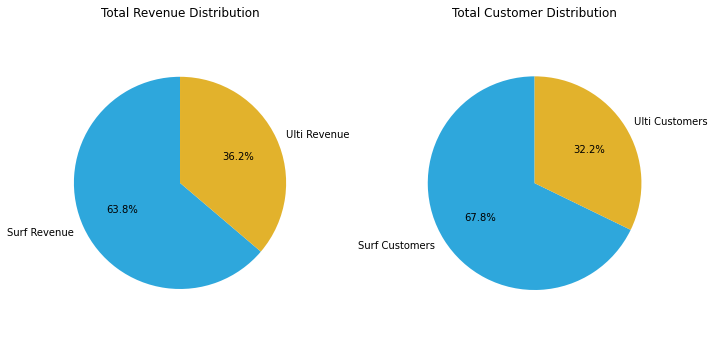

In [220]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with 1 row and 2 columns

# Revenue pie chart
revenue_labels = ['Surf Revenue', 'Ulti Revenue']
revenue_sizes = [surf_total_revenue, ulti_total_revenue]
revenue_colors = [surf_color, ulti_color]

axes[0].pie(revenue_sizes, labels=revenue_labels, colors=revenue_colors, autopct='%1.1f%%', startangle=90)
axes[0].axis('equal')
axes[0].set_title('Total Revenue Distribution')

# Customer count pie chart
customer_labels = ['Surf Customers', 'Ulti Customers']
customer_sizes = [surf_total_customers, ulti_total_customers]
customer_colors = [surf_color, ulti_color]

axes[1].pie(customer_sizes, labels=customer_labels, colors=customer_colors, autopct='%1.1f%%', startangle=90)
axes[1].axis('equal')
axes[1].set_title('Total Customer Distribution')

plt.tight_layout()  # Adjust the spacing between subplots
fig.set_facecolor('white')

folder_path = '/Users/ericross/Desktop/MegaLines_Plan_Analysis/charts'

plt.savefig(folder_path + 'megalines_pie_custrev.png')

plt.show()


In [221]:
print(f'Surf average cost per month: {stats_surf.monthly_cost.mean():.2f} $')
print(f'Ultimate average per month: {stats_ulti.monthly_cost.mean()} $')

Surf average cost per month: 72.04 $
Ultimate average per month: 71.68 $


### Conclusion

despite the fact that the Surf plan has a base cost that is over three times lower the ultimate base cost. the average monthly fee per customers is more than Ultimate plan's.  

## Average Monthly cost per user. 

What does the spread of the average cost per month by customers? 

In [222]:
surf_total_cost = pd.pivot_table(stats_surf, values='monthly_cost', index=stats_surf.index.get_level_values(0), aggfunc=['mean', 'sum'])
ulti_total_cost = pd.pivot_table(stats_ulti, values='monthly_cost', index=stats_ulti.index.get_level_values(0), aggfunc=['mean', 'sum'])
surf_total_cost.columns = ['mean_cost', 'sum_cost']
ulti_total_cost.columns = ['mean_cost', 'sum_cost']

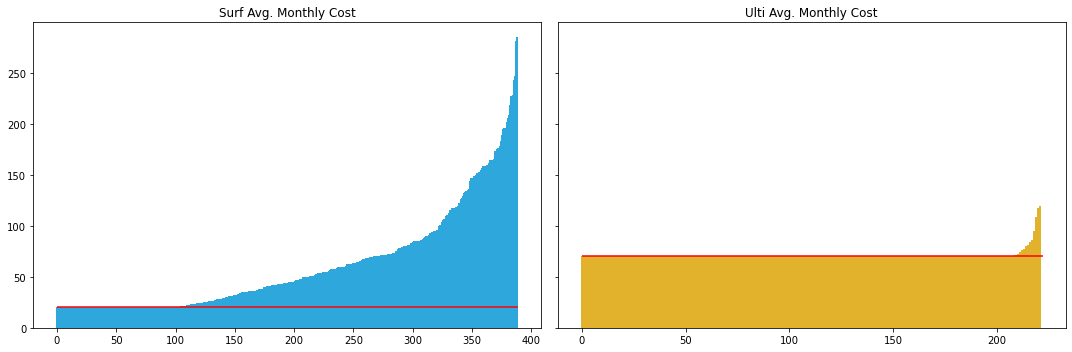

In [223]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)  # Create a figure with 1 row and 2 columns

# Plot the first bar chart in the first subplot
axes[0].bar(range(len(surf_total_cost)), surf_total_cost['mean_cost'].sort_values(), width=1, color=surf_color)
axes[0].hlines(y=20, xmin=0, xmax=389, colors='red',label='Base fee')
axes[0].set_title('Surf Avg. Monthly Cost')
# Plot the second bar chart in the second subplot
axes[1].bar(range(len(ulti_total_cost)), ulti_total_cost['mean_cost'].sort_values(), width=1, color=ulti_color )
axes[1].hlines(y=70, xmin=0, xmax=222, colors='red',label='Base fee')
axes[1].set_title('Ulti Avg. Monthly Cost')

plt.tight_layout()  # Adjust the spacing between subplots
fig.set_facecolor('white')


folder_path = '/Users/ericross/Desktop/MegaLines_Plan_Analysis/charts'

plt.savefig(folder_path + 'megalines_bar_cost_monthly.png')

plt.show()


## Overage Costs

What is the cause of the majority of the high monthly fees?  

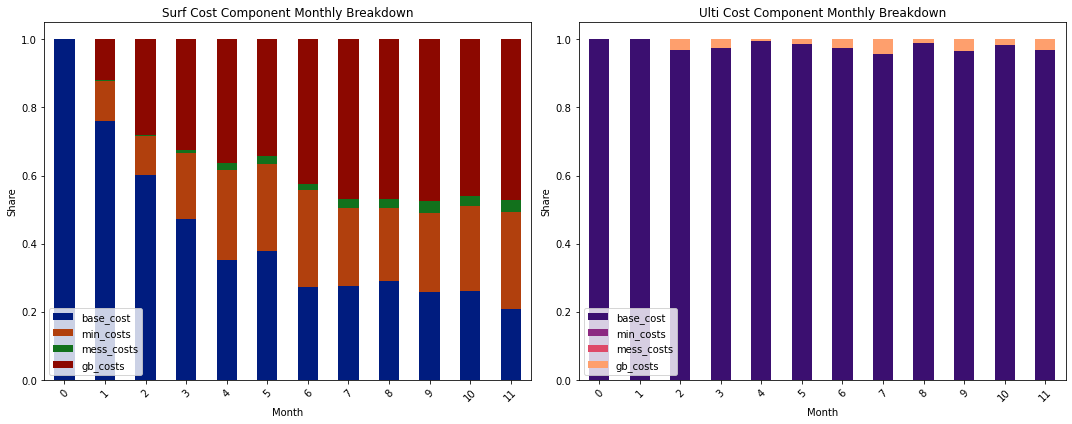

In [224]:
# Create subplots with two columns
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot the stacked bar chart for stats_surf
surf_costs = stats_surf.pivot_table(values=['base_cost', 'min_costs', 'mess_costs', 'gb_costs', 'monthly_cost'], index=stats_surf.index.get_level_values(1), aggfunc='mean', fill_value=0)
surf_cost_share = surf_costs[['base_cost', 'min_costs', 'mess_costs', 'gb_costs']].div(surf_costs['monthly_cost'], axis=0)
surf_cost_share = surf_cost_share.reset_index(drop=True)
surf_cmap = sns.color_palette('dark', n_colors=len(surf_cost_share.columns)).as_hex()
surf_ax = surf_cost_share.plot(kind='bar', stacked=True, ax=axes[0], color=surf_cmap)
surf_ax.set_xlabel('Month')
surf_ax.set_ylabel('Share')
surf_ax.set_title('Surf Cost Component Monthly Breakdown')
surf_ax.legend(loc='lower left')
surf_ax.tick_params(axis='x', rotation=45)

# Plot the stacked bar chart for stats_ulti
ulti_costs = stats_ulti.pivot_table(values=['base_cost', 'min_costs', 'mess_costs', 'gb_costs', 'monthly_cost'], index=stats_ulti.index.get_level_values(1), aggfunc='mean', fill_value=0)
ulti_cost_share = ulti_costs[['base_cost', 'min_costs', 'mess_costs', 'gb_costs']].div(ulti_costs['monthly_cost'], axis=0)
ulti_cost_share = ulti_cost_share.reset_index(drop=True)
ulti_cmap = sns.color_palette('magma', n_colors=len(ulti_cost_share.columns)).as_hex()
ulti_ax = ulti_cost_share.plot(kind='bar', stacked=True, ax=axes[1], color=ulti_cmap)
ulti_ax.set_xlabel('Month')
ulti_ax.set_ylabel('Share')
ulti_ax.set_title('Ulti Cost Component Monthly Breakdown')
ulti_ax.legend(loc='lower left')
ulti_ax.tick_params(axis='x', rotation=45)

plt.tight_layout()  # Adjust the spacing between subplots
fig.set_facecolor('white')

folder_path = '/Users/ericross/Desktop/MegaLines_Plan_Analysis/charts'

plt.savefig(folder_path + 'megalines_stackedbar_overages.png')

plt.show()


In [225]:
service_fees = stats_surf.iloc[:, -5:]
surf_overages = service_fees.pivot_table(values=['min_costs', 'mess_costs', 'gb_costs'], index=service_fees.index.get_level_values(1), aggfunc='mean', fill_value=0)

count_per_month = stats_surf.groupby(level=1).size()  # Calculate the count per month

In [277]:
surf_overages.head()

,gb_costs,mess_costs,min_costs
month,,,
1,0.000000,0.000000,0.000000
2,3.125000,0.075000,3.084375
3,9.302326,0.090698,3.809302
4,13.709677,0.420968,8.225806
5,20.609756,1.178049,14.992683


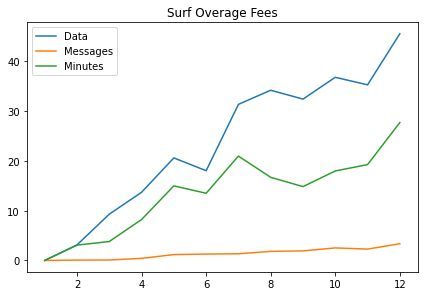

In [259]:

# Plot the second line chart in the second subplot
plt.plot(surf_overages)
plt.legend(['Data', 'Messages', 'Minutes'])

plt.tight_layout()  # Adjust the spacing between subplots
fig.set_facecolor('white')
plt.title('Surf Overage Fees')
folder_path = '/Users/ericross/Desktop/MegaLines_Plan_Analysis/charts'

plt.savefig(folder_path + 'megalines_line_overages.png')

plt.show()

In [261]:
service_fees = stats_ulti.iloc[:, -5:]
ulti_overages = service_fees.pivot_table(values=['min_costs', 'mess_costs', 'gb_costs'], index=service_fees.index.get_level_values(1), aggfunc='mean', fill_value=0)

count_per_month = stats_ulti.groupby(level=1).size()

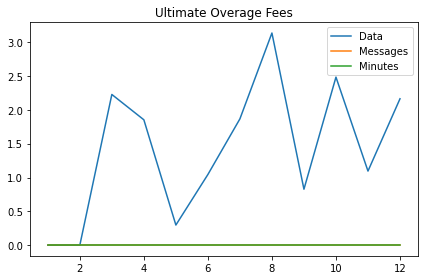

In [262]:
# Plot the second line chart in the second subplot
plt.plot(ulti_overages)
plt.legend(['Data', 'Messages', 'Minutes'])

plt.tight_layout()  # Adjust the spacing between subplots
fig.set_facecolor('white')
plt.title('Ultimate Overage Fees')

plt.tight_layout()  # Adjust the spacing between subplots
fig.set_facecolor('white')

folder_path = '/Users/ericross/Desktop/MegaLines_Plan_Analysis/charts'

plt.savefig(folder_path + 'megalines_line_overages1.png')

plt.show()

Conclusion: It seems that for both plans data overages are responsible for most of the fees for both plans. 
- On average surf users pay a majority of fees for data and minutes. 
- both plans appear to grow at the same rate respectively. 

## Analyze Churn per Plan

Could Surf have a high churn due to the nature of the overage fees being three time the base cost? 

In [228]:
churn_summary = monthly_stats[monthly_stats['churn'] == 1].groupby('tariff_id')['churn'].agg(['sum'])
churn_summary['count'] = monthly_stats['tariff_id'].value_counts()
churn_summary['percent'] = (churn_summary['sum'] / churn_summary['count']) * 100

In [229]:
churn_summary

,sum,count,percent
tariff_id,,,
0.0,23.0,1621,1.418877
1.0,11.0,925,1.189189


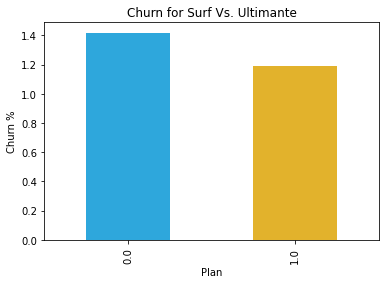

In [230]:
my_colors = [surf_color, ulti_color]

churn_summary['percent'].plot(kind='bar', color=my_colors)

plt.xlabel('Plan')
plt.ylabel('Churn %')
plt.title('Churn for Surf Vs. Ultimante')

folder_path = '/Users/ericross/Desktop/MegaLines_Plan_Analysis/charts'

plt.savefig(folder_path + 'megaelines_line_churn.png')

plt.show()


As seen above there is a higher number of churn for the surf plan, but not enough to raise concern. 

# Test statistical hypotheses

## Plan Revenue 

**Null Hypothesis (H0):** The average values of the two plans are equal, suggesting there is no significant difference between them.

**Alternative Hypothesis (H1):** The average values of the two plans are significantly different, indicating a notable distinction between them.

In [231]:
rev_mean_surf = stats_surf.monthly_cost.mean()
rev_var_surf = stats_surf.monthly_cost.var()

In [232]:
rev_mean_ulti = stats_ulti.monthly_cost.mean()
rev_var_ulti= stats_ulti.monthly_cost.var()

In [233]:
print('surf varience:',rev_var_surf , "Ultimate varience:" , rev_var_ulti)

surf varience: 5304.874878949841 Ultimate varience: 103.44727272727478


In [234]:
plan_rev_result = py.stats.ttest_ind(stats_surf['monthly_cost'], stats_ulti['monthly_cost'], equal_var=False)
plan_rev_result.pvalue

0.8456768192463132

In [235]:
alpha=0.05

In [236]:
# Test the hypotheses
print('p-value:', plan_rev_result.pvalue / 2)

if (plan_rev_result.pvalue / 2) < alpha:
    print("the null hypothesis should be rejected")
else:
    print("the null hypthesis can not be rejected")

p-value: 0.4228384096231566
the null hypthesis can not be rejected


## Conclusion - Plan Revenue 

Based on the obtained result with a p-value of 0.4228, we fail to reject the null hypothesis. This suggests that there is insufficient evidence to conclude a significant difference in revenue between the two plans. Therefore, we do not have enough statistical evidence to support the claim that the revenue generated from the two plans differs significantly.

It is important to note that failing to reject the null hypothesis does not imply that the two plans are exactly the same in terms of revenue. There might still be some differences, but the evidence from the data is not strong enough to establish those differences as statistically significant.

In [255]:
# Concatenate the DataFrames along index level 0
stats = pd.concat([stats_surf, stats_ulti], axis=0, keys=['surf', 'ulti'])

stats.head(5)

mess_count  gb_used  duration  churn state  tariff_id  \
     user_id month                                                          
surf 1001    8            30.0      7.0     187.0    0.0    WA        0.0   
             9            44.0     14.0     326.0    0.0    WA        0.0   
             10           53.0     23.0     411.0    0.0    WA        0.0   
             11           36.0     19.0     441.0    0.0    WA        0.0   
             12           44.0     20.0     422.0    0.0    WA        0.0   

                    min_over  mess_over  gb_over  base_cost  min_costs  \
     user_id month                                                       
surf 1001    8           0.0        0.0      0.0         20        0.0   
             9           0.0        0.0      0.0         20        0.0   
             10          0.0        3.0      7.0         20        0.0   
             11          0.0        0.0      3.0         20        0.0   
             12          0.0        0.0      4.0         20        0.0   

                    mess_costs  gb_costs  monthly_cost  
     user_id month                                      
surf 1001    8             0.0       0.0          20.0  
             9             0.0       0.0          20.0  
             10            0.9      70.0          90.9  
             11            0.0      30.0          50.0  
             12            0.0      40.0          60.0

## Monthly Costs - NY vs. Other States. 

### Hypothesis 
**Null Hypothesis (H0):** The average values of the two plans in the NY area are equal to the average values of the two plans in other areas, suggesting there is no significant difference between them.

**Alternative Hypothesis (H1):** The average values of the two plans in the NY area are significantly different from the average values of the two plans in other areas, indicating a notable distinction between them.

In [254]:
#selecting customer data form NY 

sample_stats_NY = stats[stats['state'].isin(['NY', 'NY-NJ-PA'])]
sample_stats_other = stats[~stats['state'].isin(['NY', 'NY-NJ-PA'])]

sample_stats_NY.state.unique(), sample_stats_other.state.unique()

(array(['NY-NJ-PA', 'NY'], dtype=object),
 array(['WA', 'NV', 'PA', 'CA', 'DC-VA-MD-WV', 'IN', 'TX', 'NE-IA',
        'NC-SC', 'AZ', 'MA-NH', 'MI', 'TN-MS-AR', 'TN', 'KY-IN', 'HI',
        'OH-KY-IN', 'OH', 'IL-IN-WI', 'LA', 'SC', 'PA-NJ-DE-MD', 'WI',
        'CT', 'RI-MA', 'MO-KS', 'VA-NC', 'OK', 'GA', 'MD', 'MN-WI',
        'OR-WA', 'FL', 'CO', 'VA', 'MO-IL', 'NM', 'AL', 'NC', 'UT'],
       dtype=object))

In [245]:
# Mean NY
rev_mean_NY = sample_stats_NY.monthly_cost.mean()

# Varience NY
rev_var_NY = sample_stats_NY.monthly_cost.var()

In [246]:
# Mean Other
rev_mean_other = sample_stats_other.monthly_cost.mean()

# Varience Other
rev_var_other= sample_stats_other.monthly_cost.var()

In [247]:
print('NY area varience:',rev_var_NY , "other area varience:" , rev_var_other)

NY area varience: 4121.640492055887 other area varience: 3242.1380834836973


In [248]:
NY_rev_results = py.stats.ttest_ind(sample_stats_NY['monthly_cost'], sample_stats_other['monthly_cost'], equal_var=True)
NY_rev_results.pvalue

0.4669595822819246

In [243]:
# Test the hypotheses
print('p-value:', NY_rev_results.pvalue / 2)

if (NY_rev_results.pvalue / 2) < alpha:
    print("the null hypothesis should be rejected")
else:
    print("the null hypthesis can not be rejected")

p-value: 0.2334797911409623
the null hypthesis can not be rejected


### Conclusion

Based on the obtained p-value of 0.21367752355125702, we fail to reject the null hypothesis. This suggests that there is no significant difference between the average values of the two plans in the NY area compared to other areas. Therefore, we do not have sufficient evidence to conclude that there is a notable distinction between the two groups.

In other words, the statistical analysis does not provide support for the claim that the average values of the two plans in the NY area differ significantly from the average values in other areas. It is important to note that failing to reject the null hypothesis does not necessarily mean that the two groups are exactly the same, but rather that the observed differences are likely due to random chance rather than a meaningful effect

# General conclusion

**Plan Conclusions:** 
Revenue from both plans do not seem to differ statistically, however the Ultimate plan seems to be more reliable in the long term with a lower churn rate. Despite Surf having slightly higher overall monthly revenue based on the data. Although, with further research into the 

Surf Plan
- ~67.8 % of Customers.
- ~63.8% of Revenue. 
- ~1.42% churn rate.   
    - Roughly 20 to 40% - of the monthly revenue is from data overage fees. 

Ultimate Plan
- ~ 32.2 % of Customers. 
- ~ 36.2 % of Revenue. 
- ~ 1.19 % churn rate.
    - Roughly  10 %  - of the monthly revenue is from data overage fees.